In [2]:
import pandas as pd
import numpy as np

In [3]:
archives_by_nfe = pd.read_csv('../output/squared_exponential_rbf/10_hypervolume.csv')
archives_by_nfe

print(f"rows: {archives_by_nfe['0'].count()}")
nfes = archives_by_nfe["Unnamed: 0"].values
u_nfes = np.unique(nfes)
selected_nfe = u_nfes[0::10]
archives_by_nfe = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe )]
print(f"Selected: {len(selected_nfe)} nfe generations:")
print(selected_nfe)
print(f"rows: {archives_by_nfe['0'].count()}")
archives_by_nfe.head()

rows: 53366
Selected: 24 nfe generations:
[  100  1100  2100  3100  4100  5100  6100  7100  8100  9100 10616 14136
 17656 21176 24696 28216 31736 35256 38776 42296 48411 65251 82091 98931]
rows: 5599


,Unnamed: 0,Unnamed: 1,0,1,2,3,4,5
0,100,0,44.126671,0.203932,0.160320,0.147804,0.081693,1.0
1,100,1,56.741342,0.427382,0.346319,0.258183,0.086821,1.0
2,100,2,48.797291,0.425752,0.384114,0.261886,0.084619,1.0
3,100,3,33.514224,0.489554,0.053261,0.324814,0.078697,1.0
4,100,4,27.248368,0.184294,0.171829,0.217182,0.075777,1.0


we need to transform the dataframe back into platypus solution instances.

We need to have a collection of solutions for each generation


In [4]:
from platypus import Solution, Problem

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomicpowerplant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
for nfe, generation in archives_by_nfe.groupby("Unnamed: 0"):
    # we slice from 2, getting rid of the first two columns 
    # which contain the NFE and ID of each solution
    archive = []
    for i, row in generation.iloc[:, 2::].iterrows():
        solution = Solution(problem)
        solution.objectives = row
        archive.append(solution)
    archives[nfe] = archive
        


in this case our reference set is the final set of solutions (only a single seed). So let's load this data as well and turn it into a set of solution in the same way as we did with the archives.

In [10]:
data = pd.read_csv('../output/squared_exponential_rbf/10_solution.csv')

ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)


In [11]:
from platypus import Hypervolume, ProcessPoolEvaluator

hv = Hypervolume(reference_set=ref_set)

nfes = []
hvs = []
for nfe, archive in archives.items():
    nfes.append(nfe)
    hvs.append(hv.calculate(archive))

In [13]:
nfes

[100,
 1100,
 2100,
 3100,
 4100,
 5100,
 6100,
 7100,
 8100,
 9100,
 10616,
 14136,
 17656,
 21176,
 24696,
 28216,
 31736,
 35256,
 38776,
 42296,
 48411,
 65251,
 82091,
 98931]

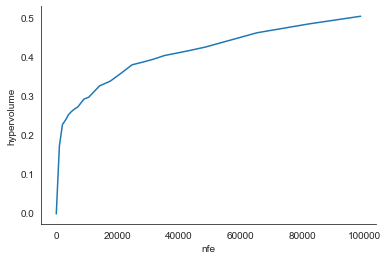

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

fig, ax = plt.subplots()

ax.plot(nfes, hvs)
ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')

sns.despine()

plt.show()

In [96]:
[s.objectives[4]-1 for s in ref_set]

[-0.5987772534639664,
 -0.595025759142706,
 -0.5941276102855118,
 -0.546417750015483,
 -0.5499870457263998,
 -0.7705061890047675,
 -0.8412301878466064,
 -0.848158081406197,
 -0.7116317394636946,
 -0.5890388552849015,
 -0.6857360327741443,
 -0.5999926024904608,
 -0.5877601821754888,
 -0.6485365662291063,
 -0.7959123515296866,
 -0.7178160606244746,
 -0.6386744796778612,
 -0.8492025917511417,
 -0.691231292161727,
 -0.5941129557560577,
 -0.5973155636495098,
 -0.5947015544729586,
 -0.792097740617619,
 -0.8373289225420759,
 -0.7483045559733913,
 -0.7473806132726627,
 -0.8024978417311395,
 -0.6453383022756605,
 -0.8108025802942231,
 -0.8415511111686832,
 -0.7051665047576555,
 -0.6939491831358309,
 -0.8332273336417275,
 -0.5795502331445317,
 -0.6391842405795114,
 -0.8470564696847631,
 -0.8378962076129782,
 -0.7058609758184238,
 -0.8275308784052062,
 -0.7831695746196936,
 -0.5733808984181508,
 -0.847718943460057,
 -0.5988463299182615,
 -0.5969672712319662,
 -0.7759091632000479,
 -0.571646525979

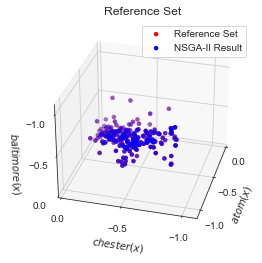

In [95]:
from mpl_toolkits.mplot3d import Axes3D

key = list(archives.keys())[-1]


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter([s.objectives[1] for s in ref_set],
           [s.objectives[2] for s in ref_set],
           [s.objectives[3] for s in ref_set],
#            [s.objectives[4]-1 for s in ref_set],
#            [s.objectives[5] for s in archives[key]],
           c="red",
           edgecolors="none",
           label="Reference Set")
ax.scatter([s.objectives[1] for s in archives[key]],
           [s.objectives[2] for s in archives[key]],
           [s.objectives[3] for s in archives[key]],
#            [s.objectives[4]-1 for s in archives[key]],
#            [s.objectives[5] for s in archives[key]],
           c="blue",
           edgecolors="none",
           label = "NSGA-II Result")
ax.set_title("Reference Set")
ax.set_xlim([0, -1.1])
ax.set_ylim([0, -1.1])
ax.set_zlim([0, -1.1])
ax.set_xlabel("$atom(x)$")
ax.set_ylabel("$chester(x)$")
ax.set_zlabel("$baltimore(x)$")
ax.view_init(elev=30.0, azim=15.0)
ax.locator_params(nbins=4)
ax.legend()
plt.show()

[-0.0002271153735325508, -0.00010281196733120596]


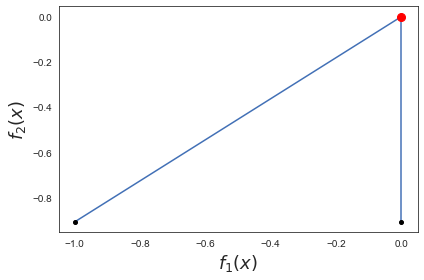

In [153]:
import numpy as np 

def plot_hyper_volume(x, y, reference_point):
    x = np.array(x)
    y = np.array(y)

    # Zip x and y into a numpy ndarray
    coordinates = np.array(sorted(zip(x, y)))

    # Empty pareto set
    pareto_set = np.full(coordinates.shape, np.inf)

    i = 0
    for point in coordinates:
        if i == 0:
            pareto_set[i] = point
            i += 1
        elif point[1] < pareto_set[:, 1].min():
            pareto_set[i] = point
            i += 1

    # Get rid of unused spaces
    pareto_set = pareto_set[:i + 1, :]

    # Add reference point to the pareto set
    pareto_set[i] = reference_point

    # These points will define the path to be plotted and filled
    x_path_of_points = []
    y_path_of_points = []

    for index, point in enumerate(pareto_set):

        if index < i - 1:
            plt.plot([point[0], point[0]], [point[1], pareto_set[index + 1][1]], marker='o', markersize=4, c='#4270b6',
                     mfc='black', mec='black')
            plt.plot([point[0], pareto_set[index + 1][0]], [pareto_set[index + 1][1], pareto_set[index + 1][1]],
                     marker='o', markersize=4, c='#4270b6', mfc='black', mec='black')

            x_path_of_points += [point[0], point[0], pareto_set[index + 1][0]]
            y_path_of_points += [point[1], pareto_set[index + 1][1], pareto_set[index + 1][1]]

    # Link 1 to Reference Point
    plt.plot([pareto_set[0][0], reference_point[0]], [pareto_set[0][1], reference_point[1]], marker='o', markersize=4,
             c='#4270b6', mfc='black', mec='black')
    # Link 2 to Reference Point
    plt.plot([pareto_set[-1][0], reference_point[0]], [pareto_set[-2][1], reference_point[1]], marker='o', markersize=4,
             c='#4270b6', mfc='black', mec='black')
    # Highlight the Reference Point
    plt.plot(reference_point[0], reference_point[1], 'o', color='red', markersize=8)
    
    # Fill the area between the Pareto set and Ref y
#     plt.fill_betweenx(y_path_of_points, x_path_of_points, max(x_path_of_points) * np.ones(len(x_path_of_points)),
#                       color='#dfeaff', alpha=1)

    plt.xlabel(r"$f_{\mathrm{1}}(x)$", fontsize=18)
    plt.ylabel(r"$f_{\mathrm{2}}(x)$", fontsize=18)
    plt.tight_layout()

    plt.show()


x = [s.objectives[1] for s in ref_set]
y = [s.objectives[2] for s in ref_set]
# x = [s.objectives[3] *-1 for s in archives[key]]
# y = [s.objectives[4] -1  for s in archives[key]]
ref = [max(x), max(y)]
print(ref)
plot_hyper_volume(x=x, y=y, reference_point=ref)

In [154]:
# x = [s.objectives[1] for s in ref_set]
# y = [s.objectives[2] for s in ref_set]
x = [s.objectives[3] *-1 for s in archives[key]]
y = [s.objectives[4] -1  for s in archives[key]]
x = np.array(x)
y = np.array(y)
coordinates = np.array(sorted(zip(x, y)))

pareto_set = np.full(coordinates.shape, np.inf)

i = 0
for point in coordinates:
    if i == 0:
        pareto_set[i] = point
        i += 1
    elif point[1] < pareto_set[:, 1].min():
        pareto_set[i] = point
        i += 1
pareto_set

array([[ 1.68914813e-04, -5.46417750e-01],
       [ 2.66646721e-02, -5.97315564e-01],
       [ 3.44695049e-02, -5.98777253e-01],
       [ 5.04832228e-02, -5.99992602e-01],
       [ 5.43643299e-02, -6.38674480e-01],
       [ 5.51223443e-02, -6.43570547e-01],
       [ 6.56411670e-02, -6.64084744e-01],
       [ 9.16454441e-02, -7.92097741e-01],
       [ 1.71248941e-01, -8.49202592e-01],
       [ 6.50947956e-01, -8.49623444e-01],
       [ 8.99619939e-01, -8.95178385e-01],
       [ 9.45443309e-01, -8.95333880e-01],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [   